In [2]:
import torch
RANDOM_SEED = 42

from sklearn.datasets import make_moons
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
n_samples = 1000
X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=RANDOM_SEED)
print(f"First 5 X features:\n{X[:5]}")
print(f"First 5 y targets:\n{y[:5]}")

First 5 X features:
[[-0.05146968  0.44419863]
 [ 1.03201691 -0.41974116]
 [ 0.86789186 -0.25482711]
 [ 0.288851   -0.44866862]
 [-0.83343911  0.53505665]]
First 5 y targets:
[1 1 1 1 0]


In [4]:
moons = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "y": y})
moons.head(10)

,X1,X2,y
0,-0.051470,0.444199,1
1,1.032017,-0.419741,1
2,0.867892,-0.254827,1
3,0.288851,-0.448669,1
4,-0.833439,0.535057,0
5,0.613706,-0.242369,1
6,0.286495,-0.201277,1
7,-0.056104,0.477079,1
8,1.604217,-0.303541,1
9,0.709641,0.858867,0


In [5]:
moons.y.value_counts()

1    500
0    500
Name: y, dtype: int64

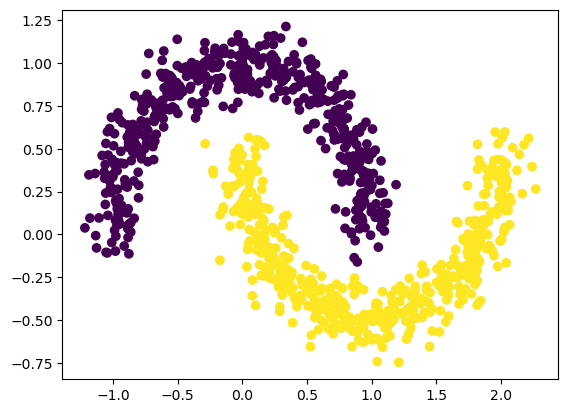

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[-0.0515,  0.4442],
         [ 1.0320, -0.4197],
         [ 0.8679, -0.2548],
         [ 0.2889, -0.4487],
         [-0.8334,  0.5351]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [18]:
from torch import nn
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(2, 5)
        self.linear2 = nn.Linear(5, 1)

    def forward(self, x):
        return self.linear2(self.linear1(x))

model_0 = MoonModelV0().to(device)
model_0

MoonModelV0(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [20]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

In [22]:
y_untrain = model_0(X_test.to(device))[5:10]
y_untrain
torch.sigmoid(y_untrain)

tensor([[0.4838],
        [0.4776],
        [0.4759],
        [0.4667],
        [0.4784]], grad_fn=<SigmoidBackward0>)

In [23]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(torch.sigmoid(y_untrain))

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [25]:
y_test[:5]
torch.eq(y_test[:5], y_preds.squeeze())

tensor([False,  True, False,  True, False])

In [26]:
torch.manual_seed(RANDOM_SEED)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train.to(device)).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train.to(device))
    acc = accuracy_fn(y_train.to(device), y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        y_test_logits = model_0(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        test_loss = loss_fn(y_test_logits, y_test.to(device))
        test_acc = accuracy_fn(y_test.to(device), y_test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.4f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Train Loss: 0.6940 | Train Acc: 50.00 | Test Loss: 0.6815 | Test Acc: 57.00
Epoch: 10 | Train Loss: 0.5723 | Train Acc: 80.00 | Test Loss: 0.5737 | Test Acc: 77.00
Epoch: 20 | Train Loss: 0.4883 | Train Acc: 81.62 | Test Loss: 0.4982 | Test Acc: 78.00
Epoch: 30 | Train Loss: 0.4287 | Train Acc: 82.12 | Test Loss: 0.4440 | Test Acc: 79.50
Epoch: 40 | Train Loss: 0.3879 | Train Acc: 82.25 | Test Loss: 0.4061 | Test Acc: 80.00
Epoch: 50 | Train Loss: 0.3604 | Train Acc: 83.12 | Test Loss: 0.3795 | Test Acc: 81.50
Epoch: 60 | Train Loss: 0.3413 | Train Acc: 83.12 | Test Loss: 0.3603 | Test Acc: 82.50
Epoch: 70 | Train Loss: 0.3275 | Train Acc: 83.62 | Test Loss: 0.3456 | Test Acc: 83.00
Epoch: 80 | Train Loss: 0.3170 | Train Acc: 83.88 | Test Loss: 0.3340 | Test Acc: 83.50
Epoch: 90 | Train Loss: 0.3086 | Train Acc: 84.62 | Test Loss: 0.3244 | Test Acc: 83.50


In [27]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


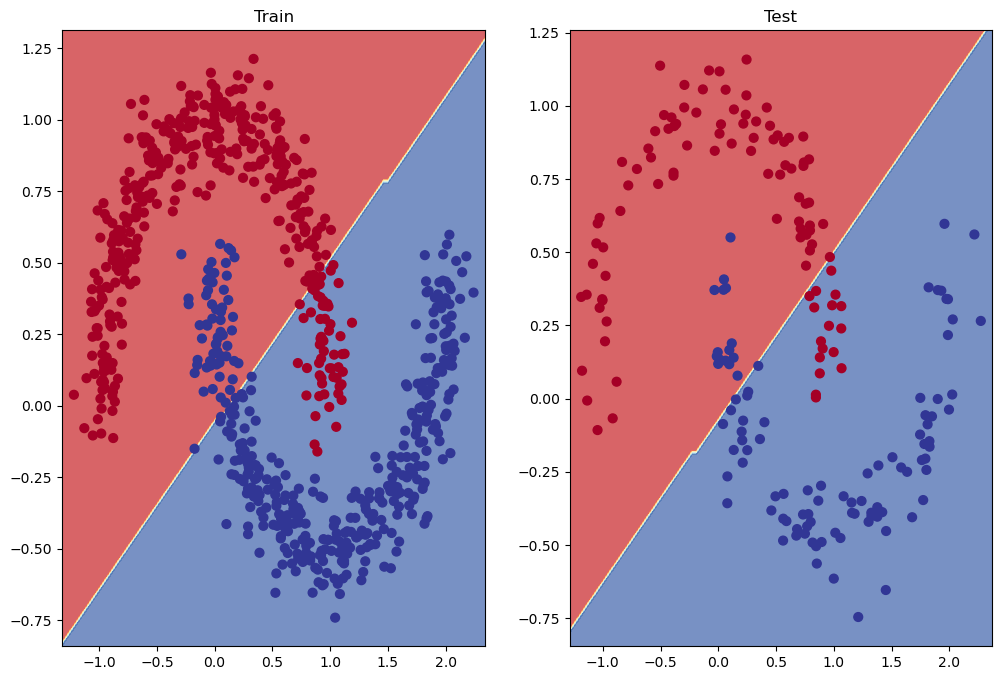

In [28]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)